# Sharded MLP (Multi-Layer Perceptron)

This notebook demonstrates the concept of a Sharded MLP, which is useful for:
- Distributed training across multiple devices
- Handling large models that don't fit in single GPU memory
- Model parallelism strategies

We'll implement:
1. A basic MLP architecture
2. Sharding strategy to split the model across multiple "devices" (simulated)
3. Forward and backward pass with sharding

## 1. Import Libraries

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from typing import List

# Set random seed for reproducibility
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Standard MLP (Non-Sharded) for Comparison

In [12]:
class StandardMLP(nn.Module):
    """Standard Multi-Layer Perceptron without sharding."""
    
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        
        layers = []
        prev_size = input_size
        
        # Build hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Create standard MLP
standard_mlp = StandardMLP(input_size=784, hidden_sizes=[512, 256, 128], output_size=10)
print("Standard MLP:")
print(standard_mlp)
print(f"\nTotal parameters: {sum(p.numel() for p in standard_mlp.parameters()):,}")

Standard MLP:
StandardMLP(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

Total parameters: 567,434


## 3. Sharded MLP Implementation

In a sharded MLP, we split the model across multiple devices. Each "shard" contains a portion of the layers.

In [ ]:
class MLPShard(nn.Module):
    """A single shard of the MLP."""
    
    def __init__(self, input_size, output_size, shard_id, device='cpu'):
        super().__init__()
        self.shard_id = shard_id
        self.device = device
        
        # Each shard has a linear layer and activation
        self.linear = nn.Linear(input_size, output_size)
        self.activation = nn.ReLU()
        
        # Move to specified device
        self.to(device)
    
    def forward(self, x):
        # Move input to this shard's device
        x = x.to(self.device)
        x = self.linear(x)
        x = self.activation(x)
        return x

class ShardedMLP(nn.Module):
    """Sharded Multi-Layer Perceptron distributed across multiple devices."""
    
    def __init__(self, input_size, hidden_sizes, output_size, devices=None):
        super().__init__()
        
        # If no devices specified, simulate with CPU
        if devices is None:
            devices = ['cpu'] * (len(hidden_sizes) + 1)
        
        self.shards = nn.ModuleList()
        self.devices = devices
        
        # Create shards for hidden layers
        prev_size = input_size
        for i, hidden_size in enumerate(hidden_sizes):
            shard = MLPShard(prev_size, hidden_size, shard_id=i, device=devices[i])
            self.shards.append(shard)
            prev_size = hidden_size
        
        # Output layer (final shard)
        self.output_layer = nn.Linear(prev_size, output_size)
        self.output_device = devices[-1]
        self.output_layer.to(self.output_device)
    
    def forward(self, x):
        # Pass through each shard sequentially
        for i, shard in enumerate(self.shards):
            x = shard(x)
            # Data is automatically moved to next shard's device
        
        # Final output layer
        x = x.to(self.output_device)
        x = self.output_layer(x)
        return x
    
    def print_shard_info(self):
        """Print information about each shard."""
        print("Sharded MLP Architecture:")
        print("=" * 60)
        for i, shard in enumerate(self.shards):
            params = sum(p.numel() for p in shard.parameters())
            print(f"Shard {i}: Device={shard.device}, "
                  f"Shape={shard.linear.weight.shape}, "
                  f"Parameters={params:,}")
        
        output_params = sum(p.numel() for p in self.output_layer.parameters())
        print(f"Output Layer: Device={self.output_device}, "
              f"Shape={self.output_layer.weight.shape}, "
              f"Parameters={output_params:,}")
        print("=" * 60)
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total Parameters: {total_params:,}")

# Create sharded MLP (simulating multiple devices with CPU)
sharded_mlp = ShardedMLP(
    input_size=784,
    hidden_sizes=[512, 256, 128],
    output_size=10,
    devices=['cpu', 'cpu', 'cpu', 'cpu']  # In practice, these would be different GPUs
)

sharded_mlp.print_shard_info()

Sharded MLP Architecture:
Shard 0: Device=cpu, Shape=torch.Size([512, 784]), Parameters=401,920
Shard 1: Device=cpu, Shape=torch.Size([256, 512]), Parameters=131,328
Shard 2: Device=cpu, Shape=torch.Size([128, 256]), Parameters=32,896
Output Layer: Device=cpu, Shape=torch.Size([10, 128]), Parameters=1,290
Total Parameters: 567,434


## 4. Compare Memory Distribution

In a real sharded setup, each shard would be on a different GPU, reducing memory pressure on each device.


Memory Distribution:

Standard MLP:
  Single Device: 2.16 MB

Sharded MLP:
  Shard 0 (cpu): 1.53 MB
  Shard 1 (cpu): 0.50 MB
  Shard 2 (cpu): 0.13 MB
  Output (cpu): 0.00 MB


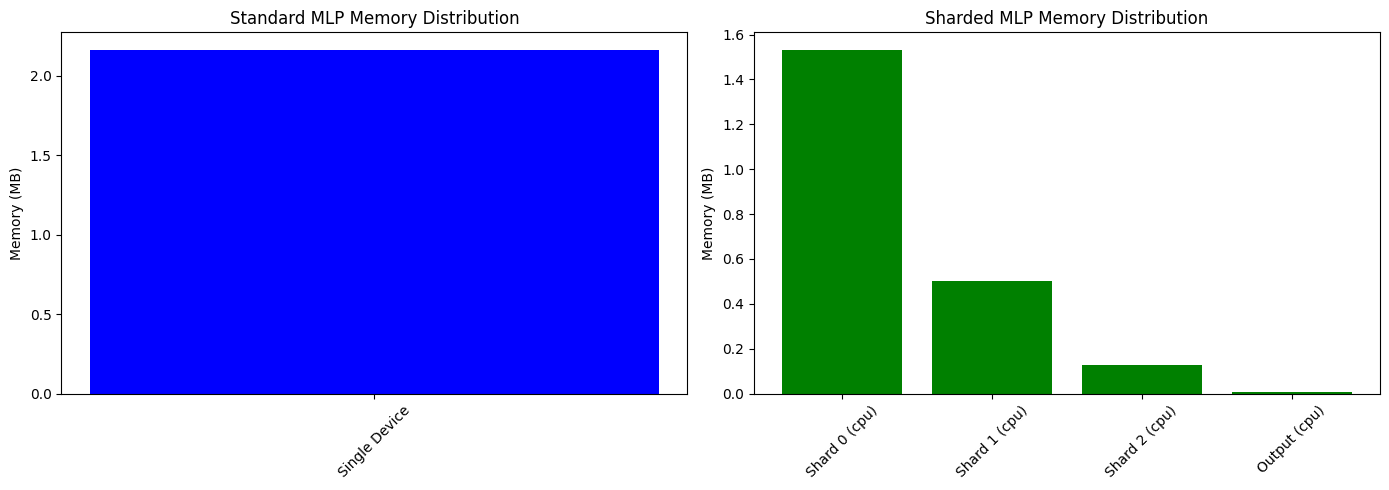

In [14]:
def calculate_memory_per_device(model):
    """Calculate memory usage per device for a sharded model."""
    device_memory = {}
    
    if isinstance(model, ShardedMLP):
        for i, shard in enumerate(model.shards):
            device = str(shard.device)
            params = sum(p.numel() * p.element_size() for p in shard.parameters())
            device_memory[f"Shard {i} ({device})"] = params
        
        # Output layer
        device = str(model.output_device)
        params = sum(p.numel() * p.element_size() for p in model.output_layer.parameters())
        device_memory[f"Output ({device})"] = params
    else:
        # Standard model - all on one device
        total_memory = sum(p.numel() * p.element_size() for p in model.parameters())
        device_memory["Single Device"] = total_memory
    
    return device_memory

# Calculate memory for both models
standard_memory = calculate_memory_per_device(standard_mlp)
sharded_memory = calculate_memory_per_device(sharded_mlp)

print("\nMemory Distribution:")
print("\nStandard MLP:")
for device, memory in standard_memory.items():
    print(f"  {device}: {memory / 1024**2:.2f} MB")

print("\nSharded MLP:")
for device, memory in sharded_memory.items():
    print(f"  {device}: {memory / 1024**2:.2f} MB")

# Visualize memory distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Standard MLP
ax1.bar(standard_memory.keys(), [m / 1024**2 for m in standard_memory.values()], color='blue')
ax1.set_ylabel('Memory (MB)')
ax1.set_title('Standard MLP Memory Distribution')
ax1.tick_params(axis='x', rotation=45)

# Sharded MLP
ax2.bar(sharded_memory.keys(), [m / 1024**2 for m in sharded_memory.values()], color='green')
ax2.set_ylabel('Memory (MB)')
ax2.set_title('Sharded MLP Memory Distribution')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Test Forward Pass

In [15]:
# Create sample input
batch_size = 8
input_data = torch.randn(batch_size, 784)

print(f"Input shape: {input_data.shape}")

# Forward pass through standard MLP
standard_mlp.eval()
with torch.no_grad():
    standard_output = standard_mlp(input_data)
print(f"Standard MLP output shape: {standard_output.shape}")

# Forward pass through sharded MLP
sharded_mlp.eval()
with torch.no_grad():
    sharded_output = sharded_mlp(input_data)
print(f"Sharded MLP output shape: {sharded_output.shape}")

# Verify outputs have same shape
print(f"\nOutputs match in shape: {standard_output.shape == sharded_output.shape}")

Input shape: torch.Size([8, 784])
Standard MLP output shape: torch.Size([8, 10])
Sharded MLP output shape: torch.Size([8, 10])

Outputs match in shape: True


## 6. Demonstrate Communication Between Shards

In [16]:
class VerboseShardedMLP(ShardedMLP):
    """Sharded MLP with verbose output to show data movement."""
    
    def forward(self, x):
        print(f"Input: shape={x.shape}, device={x.device}")
        
        for i, shard in enumerate(self.shards):
            print(f"\nProcessing Shard {i}:")
            print(f"  Before: device={x.device}")
            x = shard(x)
            print(f"  After: shape={x.shape}, device={x.device}")
        
        print(f"\nProcessing Output Layer:")
        print(f"  Before: device={x.device}")
        x = x.to(self.output_device)
        x = self.output_layer(x)
        print(f"  After: shape={x.shape}, device={x.device}")
        
        return x

# Create verbose sharded MLP
verbose_sharded = VerboseShardedMLP(
    input_size=784,
    hidden_sizes=[512, 256, 128],
    output_size=10,
    devices=['cpu', 'cpu', 'cpu', 'cpu']
)

# Demonstrate forward pass with verbose output
print("\n" + "="*60)
print("VERBOSE FORWARD PASS - Data Movement Between Shards")
print("="*60)
sample_input = torch.randn(2, 784)
with torch.no_grad():
    output = verbose_sharded(sample_input)


VERBOSE FORWARD PASS - Data Movement Between Shards
Input: shape=torch.Size([2, 784]), device=cpu

Processing Shard 0:
  Before: device=cpu
  After: shape=torch.Size([2, 512]), device=cpu

Processing Shard 1:
  Before: device=cpu
  After: shape=torch.Size([2, 256]), device=cpu

Processing Shard 2:
  Before: device=cpu
  After: shape=torch.Size([2, 128]), device=cpu

Processing Output Layer:
  Before: device=cpu
  After: shape=torch.Size([2, 10]), device=cpu


## 7. Training with Sharded MLP

In [17]:
# Generate synthetic data for demonstration
def generate_synthetic_data(num_samples=1000, input_size=784, num_classes=10):
    """Generate synthetic data for training."""
    X = torch.randn(num_samples, input_size)
    y = torch.randint(0, num_classes, (num_samples,))
    return X, y

# Generate training data
X_train, y_train = generate_synthetic_data(num_samples=1000)
X_test, y_test = generate_synthetic_data(num_samples=200)

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

# Training function
def train_model(model, X, y, epochs=10, lr=0.001, batch_size=32):
    """Train a model (standard or sharded)."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        # Mini-batch training
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size]
            batch_y = y[i:i+batch_size]
            
            # Forward pass
            outputs = model(batch_X)
            # Move target to same device as output
            batch_y = batch_y.to(outputs.device)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / (len(X) // batch_size)
        losses.append(avg_loss)
        
        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return losses

# Train sharded MLP
print("\nTraining Sharded MLP:")
print("-" * 40)
losses = train_model(sharded_mlp, X_train, y_train, epochs=10)

Training data: torch.Size([1000, 784])
Test data: torch.Size([200, 784])

Training Sharded MLP:
----------------------------------------
Epoch 2/10, Loss: 1.9180
Epoch 4/10, Loss: 0.0189
Epoch 6/10, Loss: 0.0011
Epoch 8/10, Loss: 0.0007
Epoch 10/10, Loss: 0.0005


## 8. Visualize Training Progress

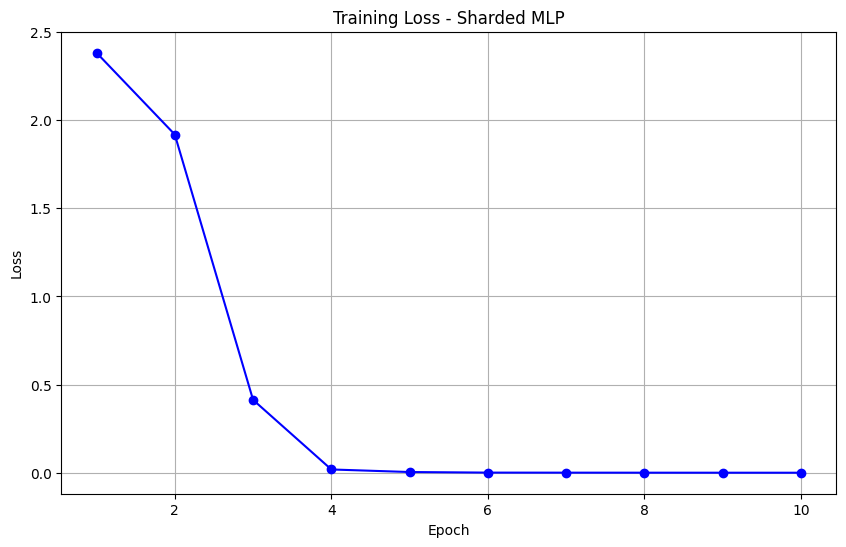

In [18]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, 'b-', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss - Sharded MLP')
plt.grid(True)
plt.show()

## 9. Evaluate Model

In [19]:
def evaluate_model(model, X, y):
    """Evaluate model accuracy."""
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        # Move y to same device as predicted
        y = y.to(predicted.device)
        accuracy = (predicted == y).sum().item() / len(y)
    return accuracy

# Evaluate
train_acc = evaluate_model(sharded_mlp, X_train, y_train)
test_acc = evaluate_model(sharded_mlp, X_test, y_test)

print(f"\nTraining Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")


Training Accuracy: 100.00%
Test Accuracy: 14.00%


## 10. Advantages of Sharded MLP

In [20]:
print("\nAdvantages of Sharded MLP:")
print("="*60)
print("1. Memory Distribution:")
print("   - Each shard uses only a fraction of total model memory")
print("   - Enables training of larger models")
print("\n2. Parallel Processing:")
print("   - Different shards can process different samples")
print("   - Pipeline parallelism possible")
print("\n3. Scalability:")
print("   - Can scale to very large models by adding more shards")
print("   - Not limited by single device memory")
print("\n4. Flexibility:")
print("   - Can place different shards on different devices")
print("   - Mix of GPU/CPU placement possible")
print("="*60)

print("\nTrade-offs:")
print("="*60)
print("1. Communication Overhead:")
print("   - Data transfer between devices takes time")
print("   - Network bandwidth can be a bottleneck")
print("\n2. Complexity:")
print("   - More complex to implement and debug")
print("   - Requires careful device placement strategy")
print("\n3. Load Balancing:")
print("   - Shards should have similar compute requirements")
print("   - Imbalanced shards lead to inefficiency")
print("="*60)


Advantages of Sharded MLP:
1. Memory Distribution:
   - Each shard uses only a fraction of total model memory
   - Enables training of larger models

2. Parallel Processing:
   - Different shards can process different samples
   - Pipeline parallelism possible

3. Scalability:
   - Can scale to very large models by adding more shards
   - Not limited by single device memory

4. Flexibility:
   - Can place different shards on different devices
   - Mix of GPU/CPU placement possible

Trade-offs:
1. Communication Overhead:
   - Data transfer between devices takes time
   - Network bandwidth can be a bottleneck

2. Complexity:
   - More complex to implement and debug
   - Requires careful device placement strategy

3. Load Balancing:
   - Shards should have similar compute requirements
   - Imbalanced shards lead to inefficiency


## Summary

This notebook demonstrated:

1. **Standard MLP**: Traditional implementation on a single device
2. **Sharded MLP**: Distributed implementation across multiple devices
3. **Memory Distribution**: How sharding reduces per-device memory usage
4. **Data Movement**: Communication between shards during forward/backward pass
5. **Training**: Complete training pipeline with sharded model

Key concepts:
- **Model Sharding**: Splitting model layers across devices
- **Device Placement**: Strategic placement of model components
- **Inter-device Communication**: Data transfer during forward/backward pass
- **Memory Efficiency**: Reduced memory footprint per device

Use cases:
- Training very large models (billions of parameters)
- Multi-GPU training with model parallelism
- Distributed deep learning systems